In [104]:
# Import Required Modules.
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt

from statistics import mean, stdev

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml
#from sklearn import datasets #when using datasets embedded in sklearn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve, silhouette_score, accuracy_score, mean_absolute_error, recall_score
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.tree  import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, LinearSVR
from sklearn.naive_bayes import GaussianNB

from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

#To display entire dataframe, we need to setup this option in Pandas
pd.set_option('display.max_rows', None)

### Utility Functions

In [105]:
#To create a dataframe using a subset of features from original dataset
def create_custom_dataframe(df, features, label_column):
    columns = features + [label_column]
    return df[columns].copy()

    
#Transform a categorical column in a given df using label encoding
def encode_column(df, column):
    df_copy = df.copy()
    
    lencoder = LabelEncoder()
    df_copy[column] = lencoder.fit_transform(df_copy[column])
    
    return df_copy

def split_dataset(X, y, test_size=None, stratify=False):
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)
    return (X_train, X_test, y_train, y_test)


def perform_cross_validation(model, X_train, y_train, folds):
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=folds, scoring='accuracy')
    print("-------Cross validation-----------")
    print(f"Training Accuracy with {folds} folds: {cv_accuracy}")
    print(f"Average Training Accuracy of {folds} folds: {cv_accuracy.mean()}")
    
def perform_stratified_sampling(model, X_train, y_train):    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    skf_accuracy = []
  
    for train_index, test_index in skf.split(X_train, y_train):
        x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        skf_accuracy.append(model.score(x_test_fold, y_test_fold))

    print("-------Stratified Kfold---------")
    print(f"Accuracy by fold: {skf_accuracy}")
    print(f"Maximum Accuracy: {max(skf_accuracy)*100}%")
    print(f"Average Accuracy: {mean(skf_accuracy)*100}%")

def build_classifiers():
    return [
        ("RandomForestClassifier", RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=27)),
        ("ExtraTreesClassifier", ExtraTreesClassifier(n_estimators=100, random_state=27)),
        ("KNNClassifier", KNeighborsClassifier()),
        ("DecisionTreeClassifier", DecisionTreeClassifier()),
        ("SVC", SVC(kernel='linear', probability=True)),
        ("GNB", GaussianNB())
    ]

#this function used to build and evalute different models 
def run_classifiers(X_train, X_test, y_train, y_test, cross_val=False, skf_val=False, folds=3):
    classifiers = build_classifiers()

    for key, model in classifiers:
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        
    print("Individual Classifiers Score Results")
    print("-----------------------------------")
    for key, model in classifiers:
        if cross_val: 
            perform_cross_validation(model, X_train, y_train, folds)
        if skf_val:
            perform_stratified_sampling(model, X_train, y_train)
        print(f"{key}: Training Accuracy: {model.score(X_train, y_train)} | Test Accuracy: {model.score(X_test, y_test)} ")
        print("-----------------------------------")
    
    print("")  
    
    
def run_ensemble_classifier(X_train, X_test, y_train, y_test, include_soft):
    
    classifiers = build_classifiers()

    voting_clf = VotingClassifier(classifiers)
    voting_clf.fit(X_train, y_train)
    y_predict = voting_clf.predict(X_test)
    
    print("Ensemble Classifier Score Results")
    print("---------------------------------")
    
    if include_soft:
        voting_clf.voting = "soft"
        print(f"Soft VotingClassifier: {voting_clf.score(X_test, y_test)}") 

    voting_clf.voting = "hard"
    print(f"Hard VotingClassifier: {voting_clf.score(X_test, y_test)}") 
    
    print("")    
    
    return voting_clf
 


In [106]:
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()

In [107]:
# print description
print(cancer_data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [108]:
# print the features
print("Features: ", cancer_data.feature_names)
# print the type of cancer
print("Labels: ", cancer_data.target_names)

Features:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Labels:  ['malignant' 'benign']


In [109]:
df = pd.DataFrame(cancer_data.data,columns=cancer_data.feature_names)
df['target'] = pd.Series(cancer_data.target)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


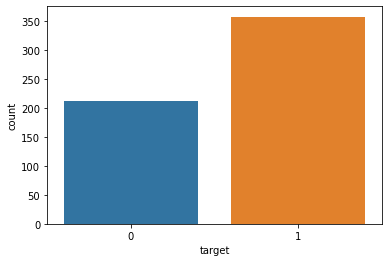

In [110]:
#Get a count of the number of (0:malignant, 1:benign) cells
df['target'].value_counts()
#Visualize this count 
sb.countplot(x=df['target'])
plt.show()

In [111]:
# Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, cancer_data.target, test_size=0.15, random_state=27)
print("Data Split Shapes")
print("-----------------")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Data Split Shapes
-----------------
X_train shape: (483, 30)
y_train shape: (483,)
X_test shape: (86, 30)
y_test shape: (86,)


## Building and evaluating models

In [112]:
run_classifiers(X_train, X_test, y_train, y_test)

Individual Classifiers Score Results
-----------------------------------
RandomForestClassifier: Training Accuracy: 0.9958592132505176 | Test Accuracy: 0.9534883720930233 
-----------------------------------
ExtraTreesClassifier: Training Accuracy: 1.0 | Test Accuracy: 0.9651162790697675 
-----------------------------------
KNNClassifier: Training Accuracy: 0.9544513457556936 | Test Accuracy: 0.9186046511627907 
-----------------------------------
DecisionTreeClassifier: Training Accuracy: 1.0 | Test Accuracy: 0.8953488372093024 
-----------------------------------
SVC: Training Accuracy: 0.9648033126293996 | Test Accuracy: 0.9651162790697675 
-----------------------------------
GNB: Training Accuracy: 0.9399585921325052 | Test Accuracy: 0.9418604651162791 
-----------------------------------



In [113]:
run_classifiers(X_train, X_test, y_train, y_test, True, skf_val=True)

Individual Classifiers Score Results
-----------------------------------
-------Cross validation-----------
Training Accuracy with 3 folds: [0.9378882  0.95031056 0.95652174]
Average Training Accuracy of 3 folds: 0.94824016563147
-------Stratified Kfold---------
Accuracy by fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9791666666666666, 1.0, 1.0, 0.9791666666666666]
Maximum Accuracy: 100.0%
Average Accuracy: 99.58333333333333%
RandomForestClassifier: Training Accuracy: 0.9958592132505176 | Test Accuracy: 0.9534883720930233 
-----------------------------------
-------Cross validation-----------
Training Accuracy with 3 folds: [0.95652174 0.9689441  0.9689441 ]
Average Training Accuracy of 3 folds: 0.9648033126293996
-------Stratified Kfold---------
Accuracy by fold: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Maximum Accuracy: 100.0%
Average Accuracy: 100.0%
ExtraTreesClassifier: Training Accuracy: 1.0 | Test Accuracy: 0.9651162790697675 
-----------------------------------
-------Cross

## Voting Classifier

In [114]:
run_ensemble_classifier(X_train, X_test, y_train, y_test, True)

Ensemble Classifier Score Results
---------------------------------
Soft VotingClassifier: 0.9418604651162791
Hard VotingClassifier: 0.9651162790697675



VotingClassifier(estimators=[('RandomForestClassifier',
                              RandomForestClassifier(max_leaf_nodes=16,
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=27)),
                             ('ExtraTreesClassifier',
                              ExtraTreesClassifier(random_state=27)),
                             ('KNNClassifier', KNeighborsClassifier()),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier()),
                             ('SVC', SVC(kernel='linear', probability=True)),
                             ('GNB', GaussianNB())])

### Displaying Decision Trees Hierarchy

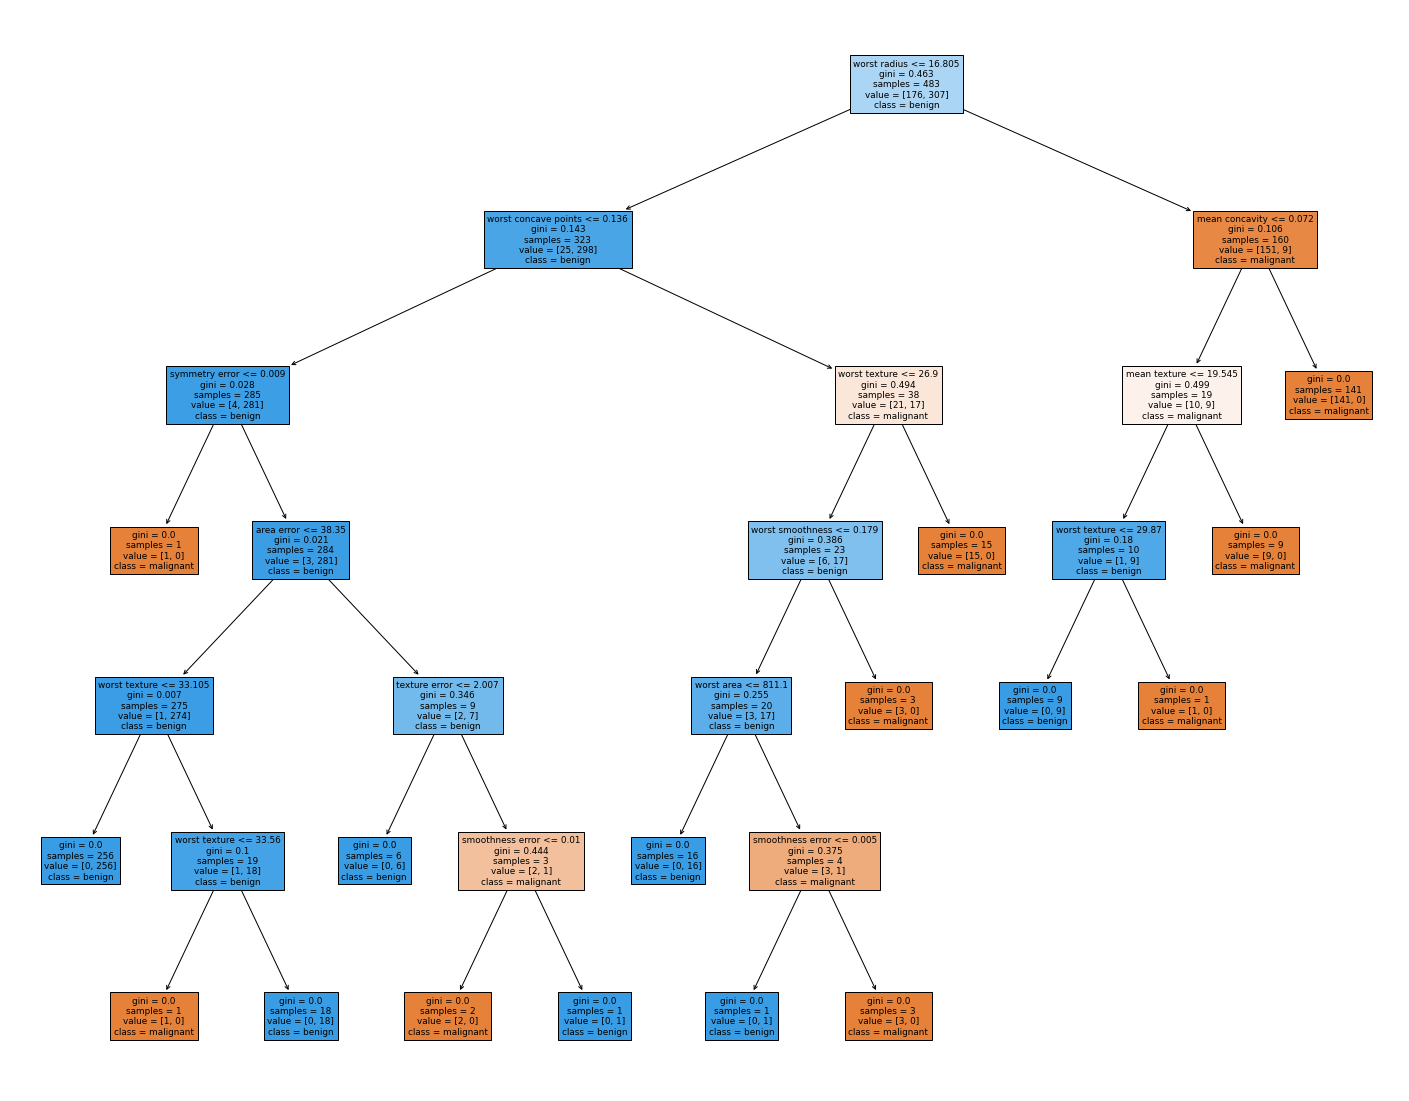

In [115]:
from sklearn import tree

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
fig=plt.figure(figsize=(25,20))
tree.plot_tree(dt_clf, 
                   feature_names=cancer_data.feature_names,  
                   class_names=cancer_data.target_names,
                   filled=True)
plt.show()

In [116]:
#You can save the decision tree graph
fig.savefig("decision_tree.png")

## Hyperparameters optimization
Finding a great combination of hyperparameter values that optimize your model's performance metric.

### GridSearchCV

In [117]:
param_grid = {'bootstrap': [True],
     'max_depth': [6, 10],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [3, 5],
     'min_samples_split': [4, 6],
     'n_estimators': [100, 350]
    }
     

forest_clf = RandomForestClassifier()

forest_grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                                  scoring="accuracy",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

forest_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [6, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [4, 6],
                         'n_estimators': [100, 350]},
             return_train_score=True, scoring='accuracy', verbose=True)

In [118]:
forest_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 100}

In [119]:
forest_grid_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=6)

In [120]:
forest_grid_search.best_score_

0.9523840206185568

### RandomizedSearchCV

In [121]:
param_space = {"bootstrap": [True],
        "max_depth": [6, 8, 10, 12, 14],
        "max_features": ['auto', 'sqrt','log2'],
        "min_samples_leaf": [2, 3, 4],
        "min_samples_split": [2, 3, 4, 5],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

forest_rand_search = RandomizedSearchCV(forest_clf, param_space, n_iter=32,
                                        scoring="accuracy", verbose=True, cv=5,
                                        n_jobs=-1, random_state=42)

forest_rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=32,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [6, 8, 10, 12, 14],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='accuracy', verbose=True)

In [122]:
forest_rand_search.best_params_

{'n_estimators': 600,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': True}

In [123]:
forest_rand_search.best_estimator_

RandomForestClassifier(max_depth=12, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=600)

In [124]:
forest_rand_search.best_score_

0.9523840206185568